In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import shutil
from keras import layers
from keras import losses
from keras.regularizers import L2
from keras import metrics
from sklearn.metrics import confusion_matrix
import tensorflow_probability as tfp
from keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/PCOSGen-train")


In [ ]:
output_folder = r"/content/drive/MyDrive/Colab Notebooks/PCOSGen-train/Image Dataset"
healthy = os.path.join(output_folder, "Healthy")
unhealthy = os.path.join(output_folder, "Unhealthy")

os.makedirs(healthy, exist_ok = True)
os.makedirs(unhealthy, exist_ok = True)

In [ ]:
dataset_path = r"/content/drive/MyDrive/Colab Notebooks/PCOSGen-train/class_label.xlsx"
df = pd.read_excel(dataset_path)
df.head()

imagePath  Healthy
0  100image13.jpg        1
1   100image2.jpg        1
2  100image65.jpg        0
3  100image71.jpg        0
4  100image83.jpg        0

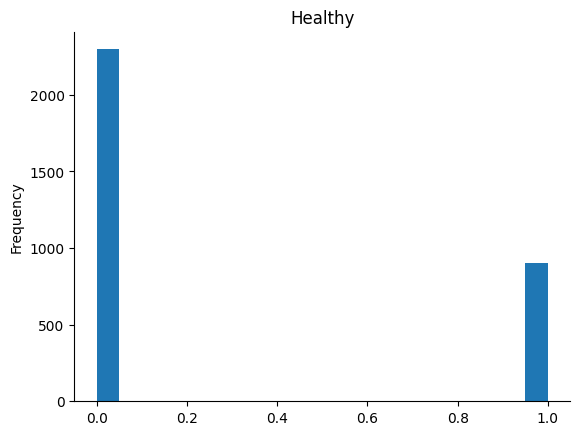

In [ ]:
df['Healthy'].plot(kind='hist', bins=20, title='Healthy')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
for index, row in df.iterrows():
  imgPath = row['imagePath']
  label = row['Healthy']

  source_path = os.path.join(r"/content/drive/My Drive/Colab Notebooks/PCOSGen-train/images",imgPath)

  if (label==1):
    dest_path = os.path.join(healthy, imgPath)
  elif (label==0):
    dest_path = os.path.join(unhealthy, imgPath)

  shutil.copyfile(source_path, dest_path)

In [ ]:
directory_path = r"/content/drive/My Drive/Colab Notebooks/PCOSGen-train/Image Dataset"
CLASS_NAMES = ["Healthy", "Unhealthy"]

In [ ]:
training_dataset, valid_dataset = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256,256),
    class_names = CLASS_NAMES,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = 'both'
)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.
Using 640 files for validation.


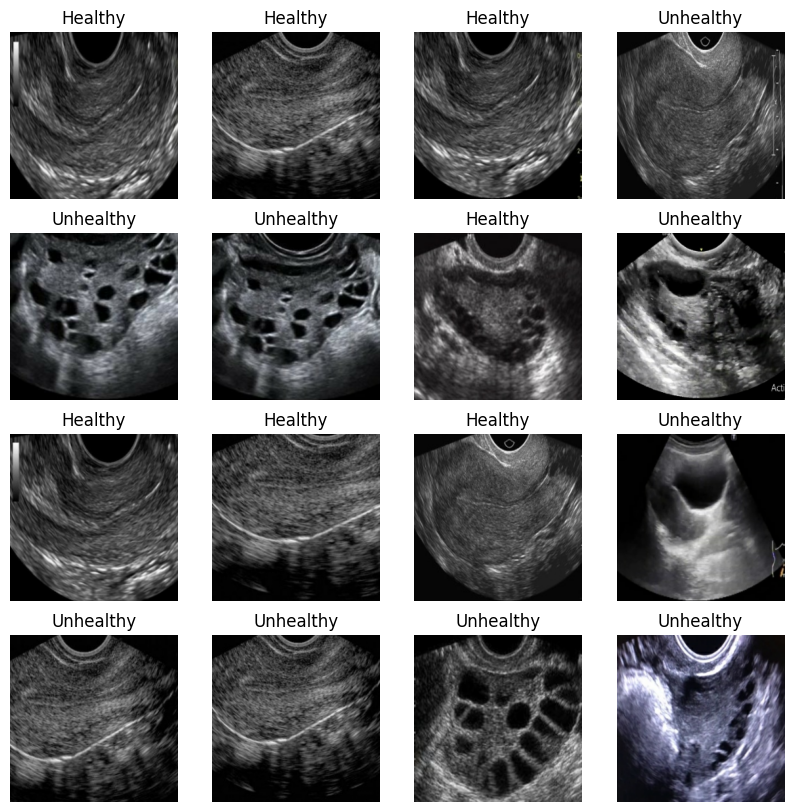

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i].numpy().astype('uint8')[0]])
    plt.axis("off")
plt.show()

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255)
])

In [ ]:
augment_layers = tf.keras.Sequential([
    layers.RandomRotation(factor = (-0.025,0.025),),
    layers.RandomFlip(mode = 'horizontal',),
    layers.RandomContrast(factor = 0.1),
])

def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [ ]:
training_dataset = (training_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))
valid_dataset = (valid_dataset.prefetch(tf.data.AUTOTUNE))

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
    "LEARNING_RATE" : 0.001,
    "N_EPOCHS" : 100,
    "DROPOUT_RATE" : 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 1024,
    "N_DENSE_2" : 128,
    "NUM_CLASSES" : 2
}

In [ ]:
lenet_model = tf.keras.Sequential([
    layers.InputLayer(input_shape = (None,None,3)),
    resize_rescale_layers,

    layers.Conv2D(filters = CONFIGURATION['N_FILTERS'], kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),
    layers.Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    layers.Conv2D(filters = CONFIGURATION['N_FILTERS']*2 + 4, kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),

    layers.Flatten(),
    layers.Dense(CONFIGURATION['N_DENSE_1'], activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    layers.Dense(CONFIGURATION['N_DENSE_2'],activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),

    layers.Dense(1, activation = 'sigmoid')

])

In [ ]:
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [ ]:
lenet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = lenet_model.fit(training_dataset, epochs = 50, validation_data = valid_dataset, verbose = 1)

Epoch 1/50
80/80 [==============================] - 309s 4s/step - loss: 0.6395 - accuracy: 0.6730 - val_loss: 2.1063 - val_accuracy: 0.2703
Epoch 2/50
80/80 [==============================] - 24s 292ms/step - loss: 0.4781 - accuracy: 0.7457 - val_loss: 2.0472 - val_accuracy: 0.2703
Epoch 3/50
80/80 [==============================] - 24s 294ms/step - loss: 0.4668 - accuracy: 0.7520 - val_loss: 1.0031 - val_accuracy: 0.3672
Epoch 4/50
80/80 [==============================] - 24s 291ms/step - loss: 0.4539 - accuracy: 0.7594 - val_loss: 0.9300 - val_accuracy: 0.4047
Epoch 5/50
80/80 [==============================] - 25s 298ms/step - loss: 0.4419 - accuracy: 0.7711 - val_loss: 0.5717 - val_accuracy: 0.6672
Epoch 6/50
80/80 [==============================] - 25s 295ms/step - loss: 0.4410 - accuracy: 0.7801 - val_loss: 0.5242 - val_accuracy: 0.6953
Epoch 7/50
80/80 [==============================] - 25s 306ms/step - loss: 0.4338 - accuracy: 0.7832 - val_loss: 0.9050 - val_accuracy: 0.4672
E

In [ ]:
drive_location = r"/content/drive/MyDrive/Colab Notebooks/"
model_filename = "lenet_model_02_02_24_1.keras"
lenet_model.save(drive_location + model_filename)

In [ ]:
lenet_model.evaluate(valid_dataset)

20/20 [==============================] - 3s 146ms/step - loss: 0.7179 - accuracy: 0.7219


[0.7179471254348755, 0.721875011920929]

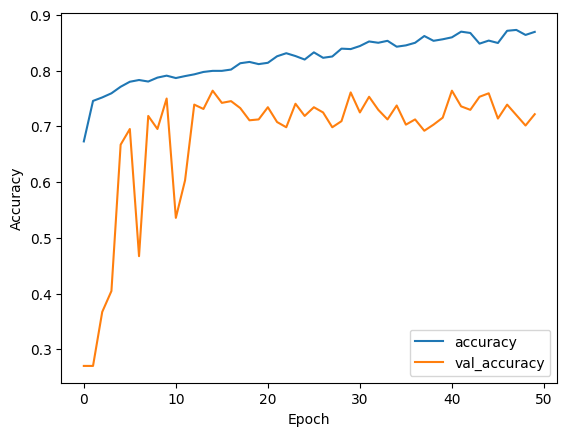

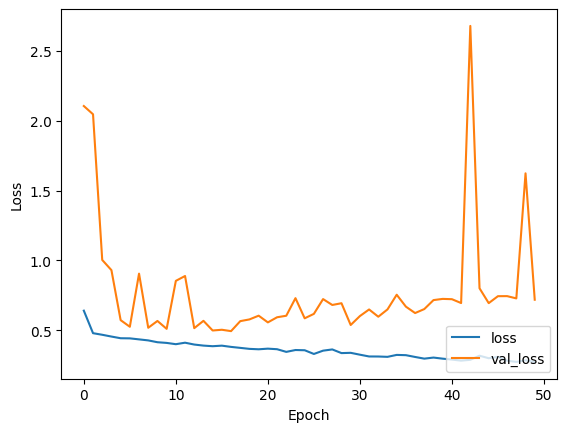

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 18ms/step


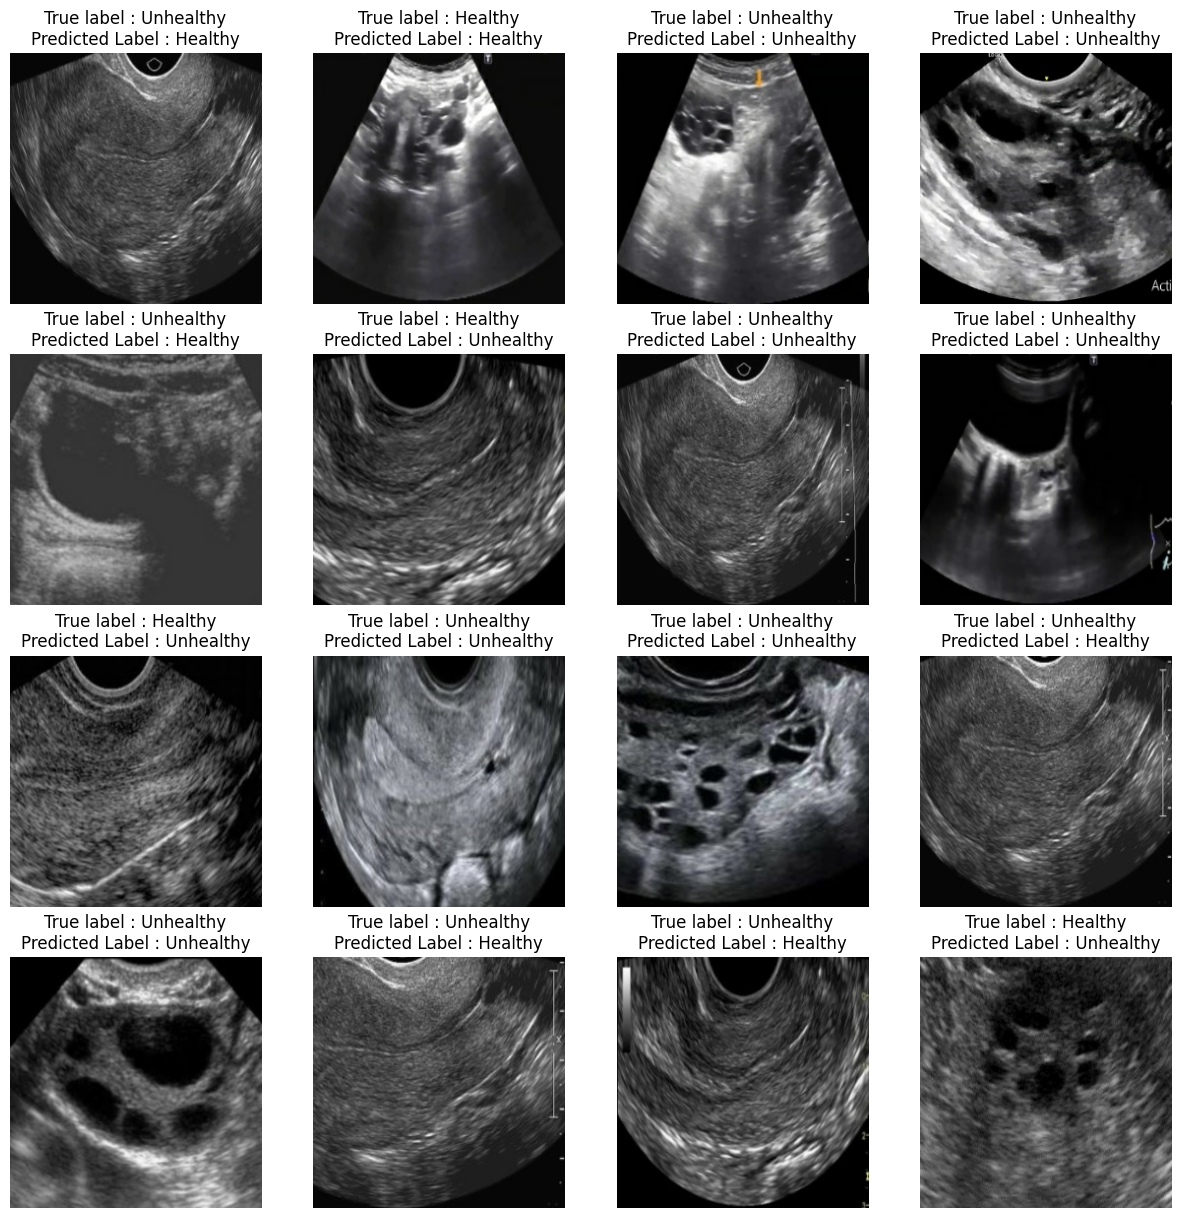

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in valid_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    predicted_label = lenet_model.predict(tf.expand_dims(images[i], axis = 0))[0][0]
    if (predicted_label >= 0.5):
      predicted_label = 1
    else:
      predicted_label = 0
    plt.title("True label : " + CLASS_NAMES[labels[i].numpy().astype('uint8')[0]] + "\n" + "Predicted Label : " + CLASS_NAMES[predicted_label])

    plt.axis('off')


In [ ]:
def prepareLabels(model, dataset):
  y_true = []
  y_pred = []

  for image,label in dataset:
    for i in range(32):
      y_true.append(label[i].numpy().astype('uint8')[0])

  for image, label in dataset:
    for i in range(32):
      value = model.predict(tf.expand_dims(image[i], axis = 0))[0][0]
      if (value>=0.5):
        y_pred.append(1)
      else:
        y_pred.append(0)
  return y_true, y_pred

1/1 [==============================] - 0s 18ms/step


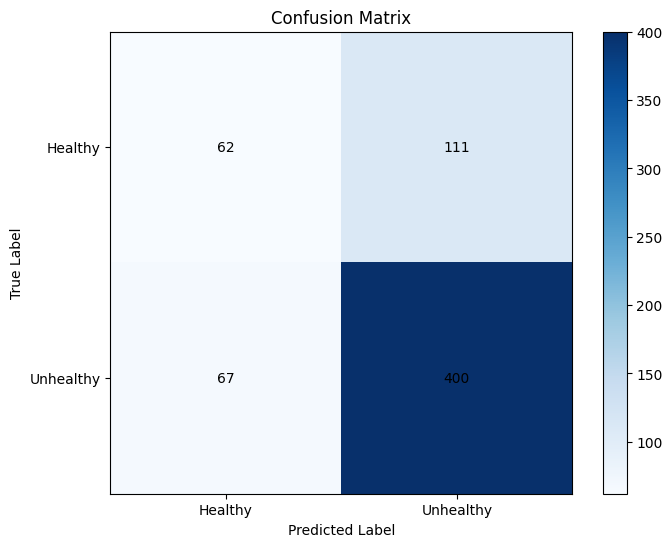

In [ ]:
def printConfusionMatrix(model,dataset):
  y_true,y_pred = prepareLabels(model, dataset)
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, cmap='Blues')
  plt.colorbar()

  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.xticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES)
  plt.yticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES)

  for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
      plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

  plt.show()

printConfusionMatrix(lenet_model, valid_dataset)

In [ ]:
def box(lamda):
  r_x = tf.cast(tfp.distributions.Uniform(0, 256).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, 256).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(256*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(256*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, 256)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, 256)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, 256)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, 256)

  r_w = x_b_r - r_x
  if (r_w==0):
    r_w = 1

  r_h = y_b_r - r_y
  if (r_h==0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, 256, 256)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, 256, 256)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1 - (r_w*r_h)/(256**2), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image,label

In [ ]:
train_dataset_1 = training_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = training_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
training_dataset_cutmix = (mixed_dataset.map(cutmix, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))

In [ ]:
training_dataset_cutmix

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
valid_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
history_cutmix = lenet_model.fit(training_dataset_cutmix, epochs = 50, validation_data = valid_dataset, verbose = 1)

Epoch 1/50
80/80 [==============================] - 86s 1s/step - loss: 0.4573 - accuracy: 0.5242 - val_loss: 0.6061 - val_accuracy: 0.7312
Epoch 2/50
80/80 [==============================] - 74s 870ms/step - loss: 0.4422 - accuracy: 0.5227 - val_loss: 0.7245 - val_accuracy: 0.7234
Epoch 3/50
80/80 [==============================] - 76s 893ms/step - loss: 0.4119 - accuracy: 0.5465 - val_loss: 0.5939 - val_accuracy: 0.7156
Epoch 4/50
80/80 [==============================] - 73s 847ms/step - loss: 0.4244 - accuracy: 0.5469 - val_loss: 0.6549 - val_accuracy: 0.7109
Epoch 5/50
80/80 [==============================] - 77s 918ms/step - loss: 0.4253 - accuracy: 0.5305 - val_loss: 0.5595 - val_accuracy: 0.7281
Epoch 6/50
80/80 [==============================] - 81s 954ms/step - loss: 0.4104 - accuracy: 0.5219 - val_loss: 0.5913 - val_accuracy: 0.7141
Epoch 7/50
80/80 [==============================] - 72s 849ms/step - loss: 0.4233 - accuracy: 0.5262 - val_loss: 0.5424 - val_accuracy: 0.7234
Ep

In [ ]:
drive_location = r"/content/drive/MyDrive/Colab Notebooks/"
model_filename = "lenet_model_history_cutmix_02_02_24_1.keras"
lenet_model.save(drive_location + model_filename)

In [ ]:
lenet_model.evaluate(valid_dataset)

20/20 [==============================] - 2s 95ms/step - loss: 0.6437 - accuracy: 0.7375


[0.6437098383903503, 0.737500011920929]

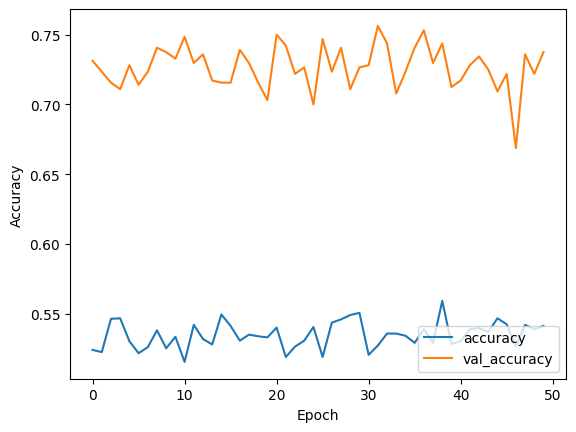

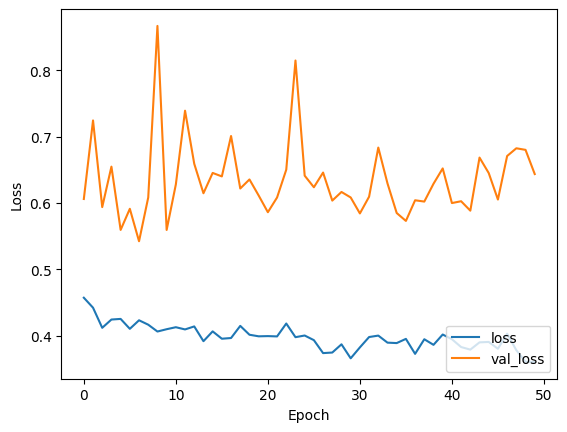

In [ ]:
plt.plot(history_cutmix.history['accuracy'], label='accuracy')
plt.plot(history_cutmix.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history_cutmix.history['loss'], label='loss')
plt.plot(history_cutmix.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 18ms/step


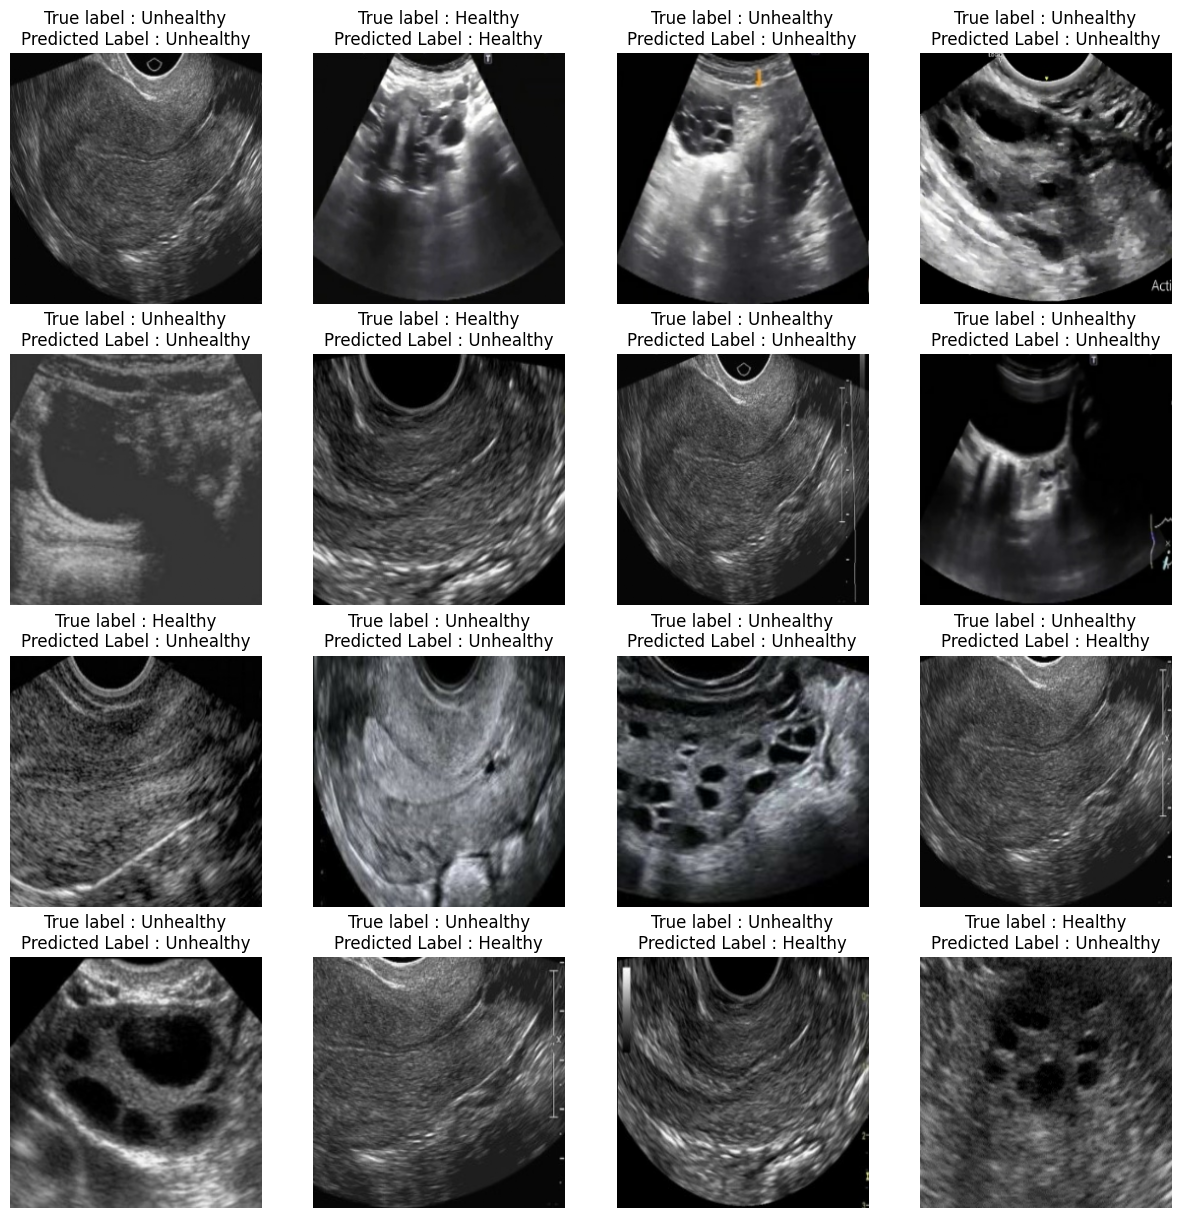

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in valid_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    predicted_label = lenet_model.predict(tf.expand_dims(images[i], axis = 0))[0][0]
    if (predicted_label >= 0.5):
      predicted_label = 1
    else:
      predicted_label = 0
    plt.title("True label : " + CLASS_NAMES[labels[i].numpy().astype('uint8')[0]] + "\n" + "Predicted Label : " + CLASS_NAMES[predicted_label])

    plt.axis('off')


1/1 [==============================] - 0s 25ms/step


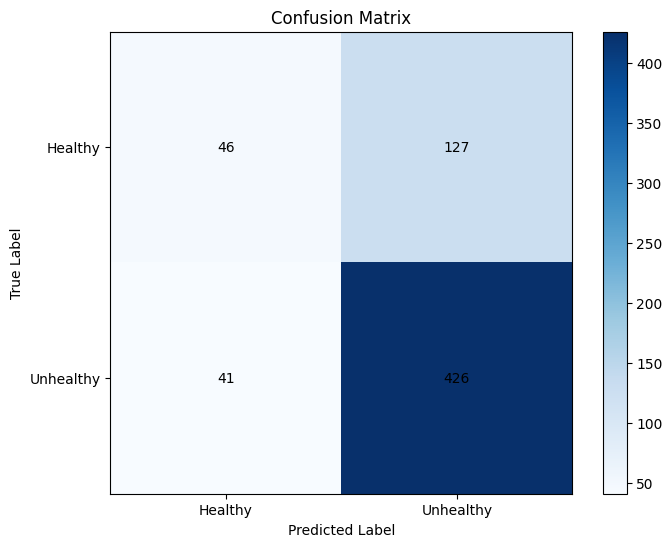

In [ ]:
printConfusionMatrix(lenet_model, valid_dataset)

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256, 256, 3),
)

71686520/71686520 [==============================] - 1s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
CONFIGURATION["N_DENSE_1"]

1024

In [ ]:
model = tf.keras.Sequential([
    layers.Input(shape = (256, 256, 3)),
    backbone,
    layers.GlobalAveragePooling2D(),
    layers.Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_3 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_4 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                      

In [ ]:
model.compile(optimizer = optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(training_dataset, validation_data = valid_dataset, epochs = 50, verbose = 1)

Epoch 1/50
80/80 [==============================] - 58s 496ms/step - loss: 0.6331 - accuracy: 0.7207 - val_loss: 0.6479 - val_accuracy: 0.6156
Epoch 2/50
80/80 [==============================] - 31s 369ms/step - loss: 0.4971 - accuracy: 0.7496 - val_loss: 0.4631 - val_accuracy: 0.7312
Epoch 3/50
80/80 [==============================] - 29s 344ms/step - loss: 0.4779 - accuracy: 0.7547 - val_loss: 0.4468 - val_accuracy: 0.7812
Epoch 4/50
80/80 [==============================] - 29s 349ms/step - loss: 0.4562 - accuracy: 0.7645 - val_loss: 0.5363 - val_accuracy: 0.7500
Epoch 5/50
80/80 [==============================] - 28s 340ms/step - loss: 0.4475 - accuracy: 0.7625 - val_loss: 0.4929 - val_accuracy: 0.7250
Epoch 6/50
80/80 [==============================] - 28s 340ms/step - loss: 0.4436 - accuracy: 0.7703 - val_loss: 0.5247 - val_accuracy: 0.7000
Epoch 7/50
80/80 [==============================] - 29s 345ms/step - loss: 0.4387 - accuracy: 0.7652 - val_loss: 0.5290 - val_accuracy: 0.7406

In [ ]:
drive_location = r"/content/drive/MyDrive/Colab Notebooks/"
model_filename = "efficientnet_b4_model_02_02_24_1.keras"
model.save(drive_location + model_filename)

In [ ]:
model.evaluate(valid_dataset)

20/20 [==============================] - 4s 189ms/step - loss: 0.4652 - accuracy: 0.7703


[0.46520575881004333, 0.770312488079071]

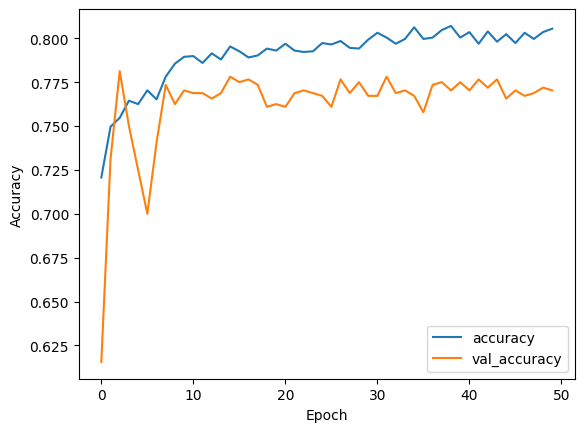

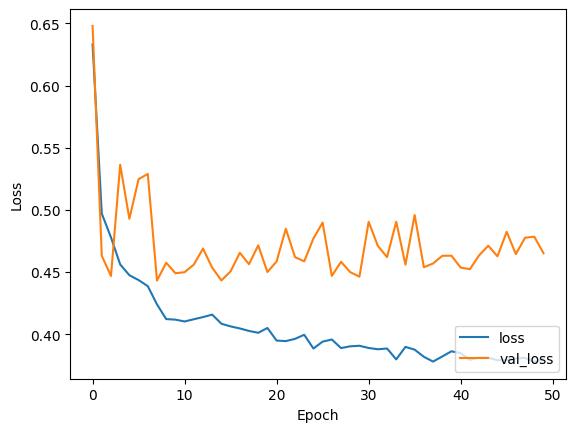

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 34ms/step


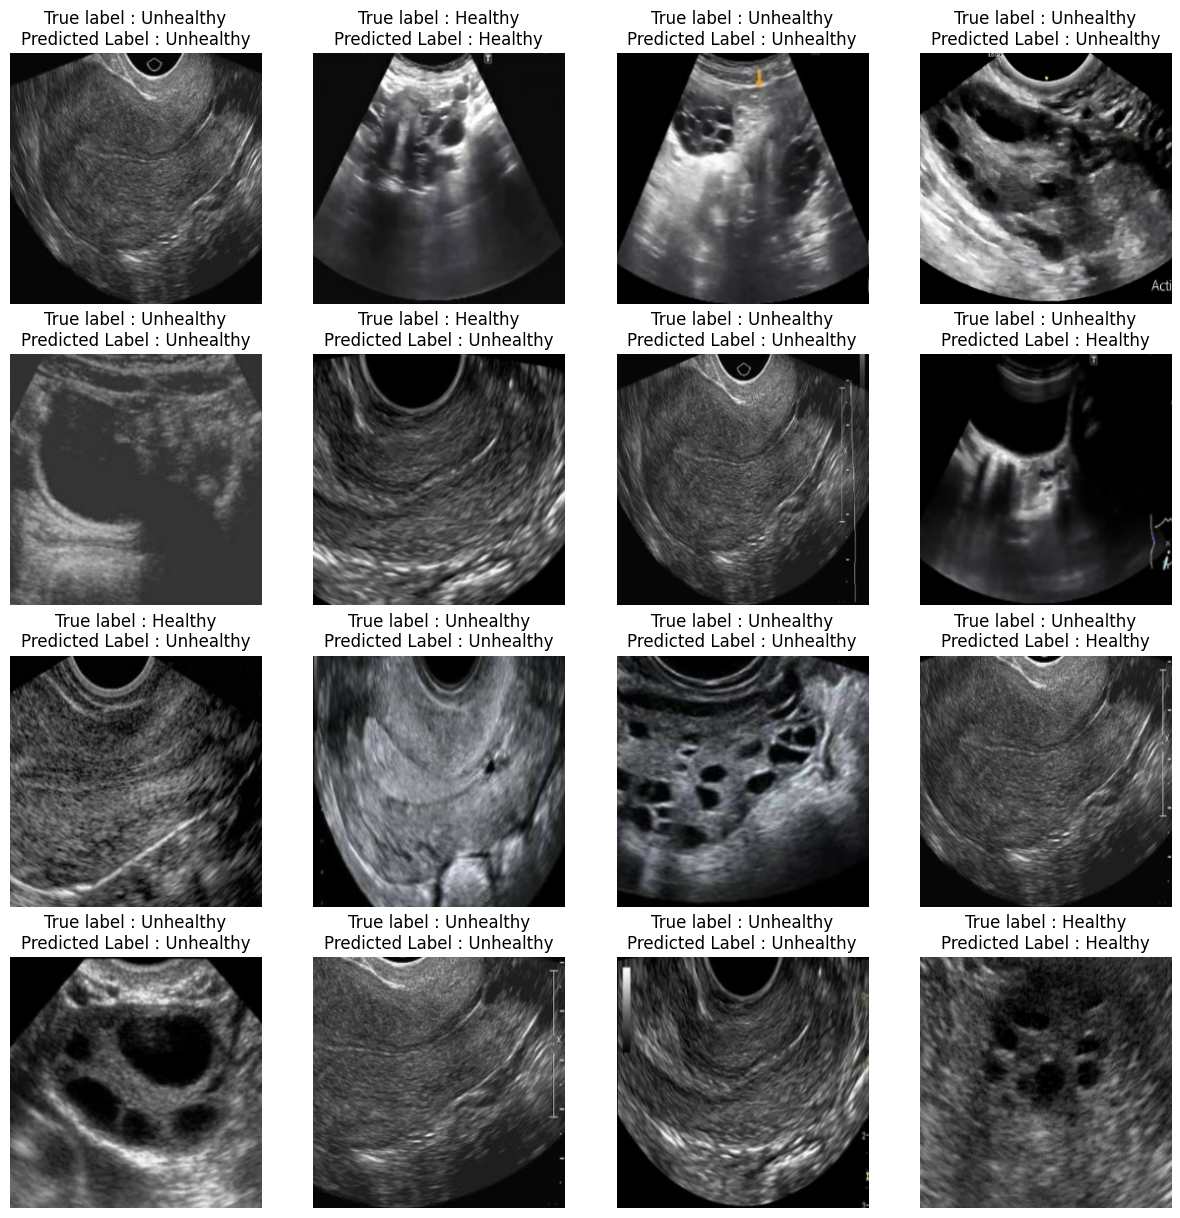

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in valid_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    predicted_label = model.predict(tf.expand_dims(images[i], axis = 0))[0][0]
    if (predicted_label >= 0.5):
      predicted_label = 1
    else:
      predicted_label = 0
    plt.title("True label : " + CLASS_NAMES[labels[i].numpy().astype('uint8')[0]] + "\n" + "Predicted Label : " + CLASS_NAMES[predicted_label])

    plt.axis('off')

1/1 [==============================] - 0s 30ms/step


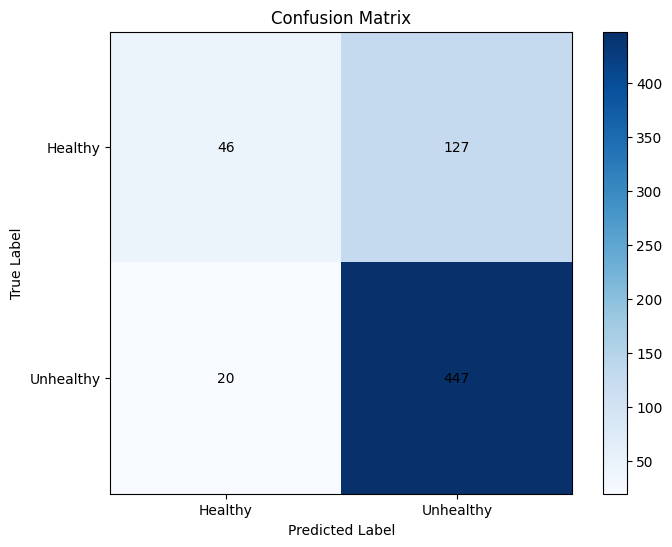

In [ ]:
printConfusionMatrix(model, valid_dataset)